# Object detection
This demo downloads a pretrained object detection network and performs inference on an image. Notebook adapted from https://www.tensorflow.org/hub/tutorials/tf2_object_detection


## Import libraries

In [ ]:
# Import tensorflow and keras
import tensorflow as tf

# import useful libraries
import numpy as np # required to perform operations on arrays
import pandas as pd # library for handling dataframes
import seaborn as sns #library for visualization
import matplotlib as mpl #library for visualization
import matplotlib.pyplot as plt # visualization tool
from matplotlib import cm # color definitions
from PIL import Image, ImageDraw, ImageFont # other visualization libraries
from six import BytesIO # library to open files
from six.moves.urllib.request import urlopen # function to open online images
import tensorflow_hub as hub # tensorflow hub to load pretrained models
import logging
import time

seed = 42
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)


# useful functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.14.0


In [ ]:
# Fix randomness and hide warnings

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

np.random.seed(seed)

import random
random.seed(seed)

Definition of some useful functions.

## 0. Load Data
We download from the wen three images to be used in inference.

In [ ]:
def load_image_into_numpy_array(path):
  """Function to load a local or online image in the format we require
  Args:
    path: path to the image, either local (e.g. ./ [...] /example.jpg) or online
          (e.g. http:// [...] /example.png)
  Returns:
    The image in the format required by our network, with shape
      [1, n_rows, n_columns, 3]
  """
  image = None
  if(path.startswith('http')):
    # If the image is online, performs a request and downloads it
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    # If the image is stored locally, it is opened
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  # Transforms the image into the network's input, reshaping to
  # [1, n_rows, n_columns, 3] to account for the batch size. As we are in
  # inference mode, it will be 1
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

# Examples of online image paths. This is a dictionary having the name of image as key
image_paths = {
  'Beach' : 'https://live.staticflickr.com/4009/4678754542_fd42c6bbb8_b.jpg',
  'Road': 'http://farm5.staticflickr.com/4076/4825413441_09f2091127_z.jpg',
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
}

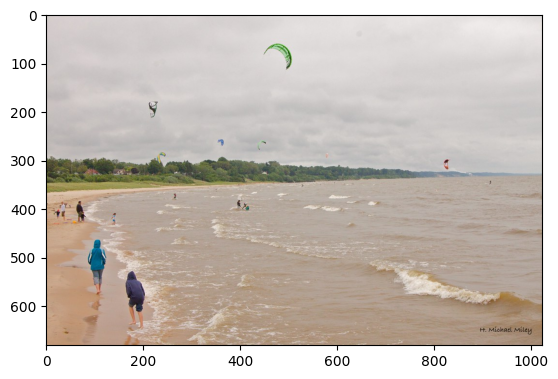

In [ ]:
# We select, download and plot one of the example images
image_path = image_paths["Beach"]
image_np = load_image_into_numpy_array(image_path)

plt.imshow(image_np[0])
plt.show()

## Define Model Architecture
We use a pre-trained [Faster R-CNN](https://arxiv.org/abs/1506.01497) model for object detection downloaded from the [Object Detection Tensorflow Hub](https://tfhub.dev/tensorflow/collections/object_detection/1).

In [ ]:
# Our model's name and URL to download it
model_name = "Faster R-CNN Inception ResNet V2 1024x1024"
model_handle = "https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1"

In [ ]:
# Now we load the model (will take some time)
print("Loading model...")
start = time.time()
hub_model = hub.load(model_handle)
print(f"Model loaded! Loading time: {time.time()-start:.2f}s")

Loading model...
Model loaded! Loading time: 36.23s


We use the model's confidence to filter its predictions. A value closer to 1 will keep only the predictions over which the model is really confident. A minimum confidence close to 0 will instead include many more predictions, even if their score is low and thus probably incorrect.

You can modify this value to see its impact in the inference section.

In [ ]:
# Confidence threshold
minimum_confidence = 0.5

## Model Training
The model we downloaded is already trained on the [COCO dataset](https://cocodataset.org/#home) so we skip this step.

## Inference
### Step by step.

We first define some visualization functions

In [ ]:
# Prepare a dictionary that associate the model's predicted class value (number) and its label (text)
category_index = {1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'microwave', 79: 'oven', 80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book', 85: 'clock', 86: 'vase', 87: 'scissors', 88: 'teddy bear', 89: 'hair drier', 90: 'toothbrush'}

# Here we define a different color for each COCO class
colors = [tuple((color * 255).astype(int))
          for color in cm.rainbow(np.linspace(0, 1, len(category_index)))]

def plot_predicted_confidence(scores, min_confidence):
  """Function to plot the confidence of predictions and visualize the threshold
  induced by the minimum confidence value.

  Args:
    scores: the confidence scores, as predicted by the model
    min_confidence: the confidence threshold under which predictions are
      discarded
  """
  # Predictions are already ordered by decreasing score, so we find the index of
  # the last score over the threshold
  lowest_kept = np.argwhere(scores >= min_confidence)[-1, 0]
  print(f"Number of predictions with confidence >= {min_confidence}:"
        f" {lowest_kept+1}")

  # We then plot the actual predictions with a continuous line
  plt.plot(scores[:lowest_kept+1], color="tab:blue",
           label="Confidence of predictions")
  # We show discarded predictions with a dashed line
  offset_plot = [None for _ in range(lowest_kept)] \
                  + list(scores[lowest_kept:])
  plt.plot(offset_plot, ls='--', color="tab:blue")
  # Finally, we show the threshold induced by the minimum confidence
  plt.axvline(lowest_kept + 0.5, color='red',
              label=f"Threshold (min_confidence = {min_confidence})")

  plt.xlabel("Predictions")
  plt.ylabel("Confidence score")
  plt.legend()
  plt.show()

def show_prediction(image, show_boxes, show_classes, show_scores,
                    max_boxes_to_draw=200, figsize=(15, 15)):
  """Visualization function for the model's predictions.

  Args:
    image: the input image
    show_boxes: the boxes predicted by the model
    show_classes: the classes predicted by the model
    show_scores: the confidence scores predicted by the model
    max_boxes_to_draw: limit on the number of predictions to display
    figsize: dimensions of the predicted image's plot
  """
  # If the image is in the format required by the model (i.e. [1, h, w, 3]) we
  # remove the first dimension
  show_image = image[0] if image.shape[0] == 1 else image
  # We then initialize the image to show the prediction
  pil_image = Image.fromarray(show_image).convert('RGBA')

  # As the predicted boxes are normalized in [0, 1], we rescale them to the
  # image's shape
  image_height = show_image.shape[0]
  image_width = show_image.shape[1]
  resize_factor = [image_height, image_width, image_height, image_width]
  full_boxes = resize_factor * show_boxes

  # We select at most max_boxes_to_draw predictions
  final_boxes = full_boxes[:max_boxes_to_draw]
  final_classes = show_classes[:max_boxes_to_draw]
  final_scores = show_scores[:max_boxes_to_draw]

  # We then draw the selected boxes, their labels and their confidence score
  # over the initial image
  font = ImageFont.load_default()
  image_draw = ImageDraw.Draw(pil_image)
  for box, cls, score in zip(final_boxes, final_classes, final_scores):
    y_0, x_0, y_1, x_1 = box
    image_draw.rectangle((x_0, y_0, x_1, y_1), outline=colors[cls], width=3)
    text = f"{category_index[cls]} {score:.2f}"
    text_position = (x_1 + 2, y_0)
    text_width, text_height = font.getsize(text)
    margin = np.ceil(0.05 * text_height)
    image_draw.rectangle((x_1 + 2 - margin,
                          y_0 - margin,
                          x_1 + 2 + text_width + margin,
                          y_0 + text_height + margin), fill=colors[cls])
    text_color = "black" if sum(colors[cls][:3]) > 500 else "white"
    image_draw.text(xy=text_position, text=text, fill=text_color)

  plt.figure(figsize=figsize)
  plt.imshow(pil_image)
  plt.show()

Inference steps

In [ ]:
# Now we perform the inference over our selected image. The model will take
# ~20s the first it is called
start = time.time()

# We invoke the model; this is equivalent to predicting the detection
# bounding boxes over the example image
results = hub_model(image_np)

# Now we convert each predicted tensor to a NumPy array for further processing
result = {key:value.numpy() for key,value in results.items()}
print(f"Inference time: {time.time()-start:.2f}s")

Inference time: 22.37s


In [ ]:
# Here we select the results. As the network took as input a batch of images having shape
# [1, n_rows, n_columns, 3], all the outputs have the batch dimension as well
# (e.g. for boxes the shape is [1, n_boxes, 4]). We therefore remove the batch
# dimension by selecting the first (and only) element for each result.
classes = result['detection_classes'][0].astype(int)
boxes = result['detection_boxes'][0]
confidence_scores = result['detection_scores'][0]

In [ ]:
# Display a few prediction
# TODO: inspect them!

print("Total predictions:", len(classes))

for example_prediction in np.arange(100):
  if confidence_scores[example_prediction] > 0.75:
    print("Example prediction nr", example_prediction, ":")
    print("\tPredicted class:", category_index[classes[example_prediction]])
    print("\tPredicted box:", boxes[example_prediction])
    print("\tModel confidence:", confidence_scores[example_prediction])

Total predictions: 100
Example prediction nr 0 :
	Predicted class: person
	Predicted box: [0.7764489  0.15975602 0.9536597  0.19966722]
	Model confidence: 0.9987325
Example prediction nr 1 :
	Predicted class: kite
	Predicted box: [0.08954266 0.4392561  0.16954987 0.49606267]
	Model confidence: 0.9985946
Example prediction nr 2 :
	Predicted class: person
	Predicted box: [0.6825193  0.08274613 0.84544957 0.12309042]
	Model confidence: 0.9983741
Example prediction nr 3 :
	Predicted class: kite
	Predicted box: [0.43816802 0.8027354  0.46886268 0.81598645]
	Model confidence: 0.9960366
Example prediction nr 4 :
	Predicted class: kite
	Predicted box: [0.26292717 0.20626365 0.31179923 0.22641125]
	Model confidence: 0.9955646
Example prediction nr 5 :
	Predicted class: kite
	Predicted box: [0.37796798 0.3460384  0.3996359  0.35885736]
	Model confidence: 0.9665726
Example prediction nr 6 :
	Predicted class: kite
	Predicted box: [0.38055792 0.42660922 0.40982717 0.4445746 ]
	Model confidence: 0.9

We now select only predictions with confidence higher than our defined threshold

Number of predictions with confidence >= 0.5: 15


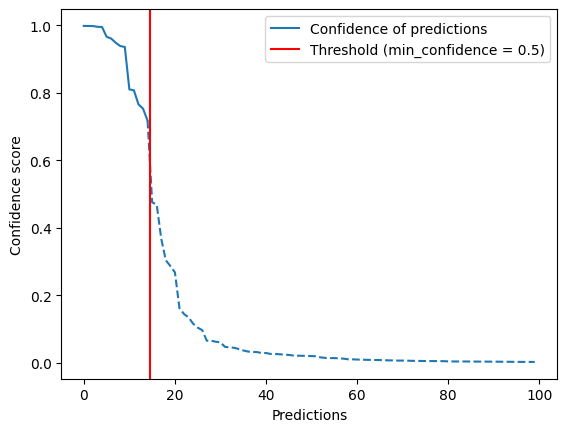

In [ ]:
# Here we show which predictions are kept or discarded according to their
# confidence score
plot_predicted_confidence(confidence_scores, minimum_confidence)

In [ ]:
# Now we actually discard the low-confidence predictions
over_threshold_mask = confidence_scores >= minimum_confidence
final_boxes = boxes[over_threshold_mask]
final_classes = classes[over_threshold_mask]
final_scores = confidence_scores[over_threshold_mask]

Finally, we display our prediction and an example of processing.

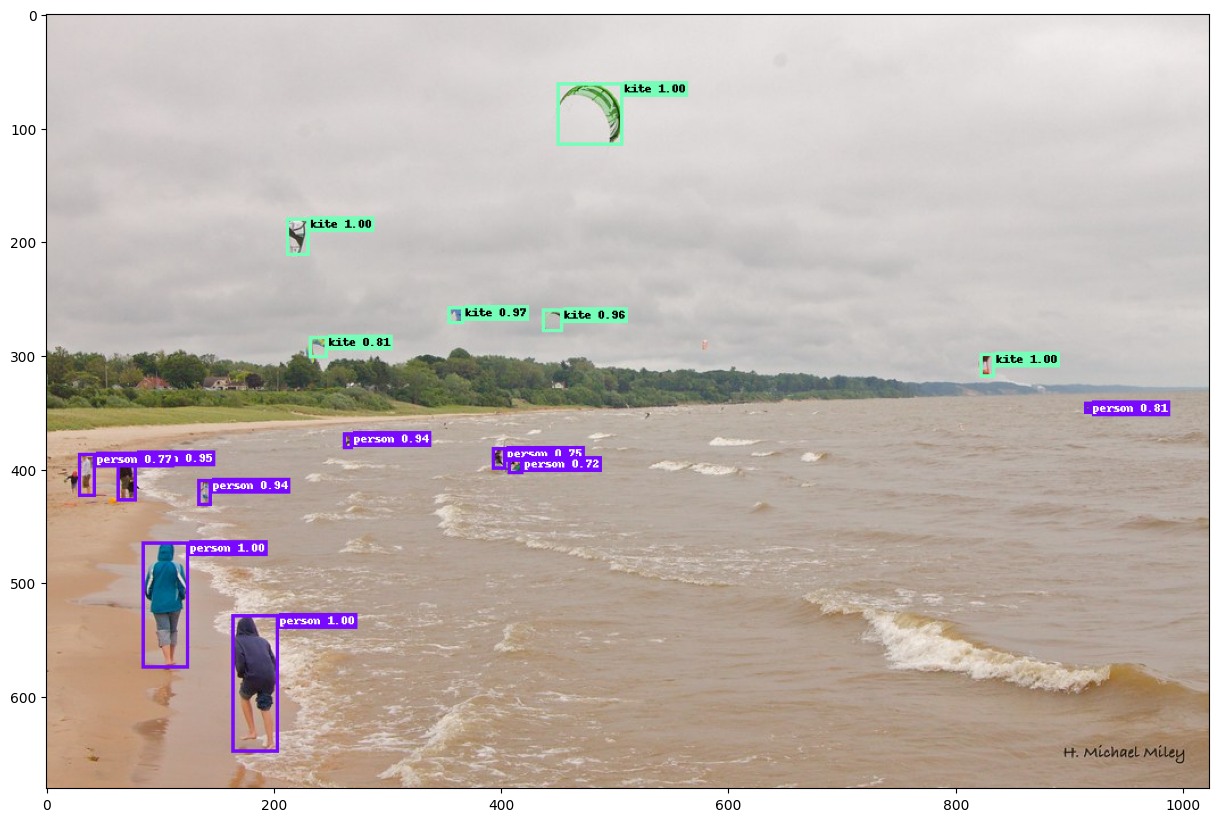

In [ ]:
show_prediction(image_np, final_boxes, final_classes, final_scores)

In [ ]:
def print_prediction_count(image, classes, boxes, label_dict=category_index):
  """
  Counts and displays the number of instances in the image.

  Args:
    classes: the final classes predicted by the model
    boxes: the final boxes predicted by the model
    label_dict: the dictionary associating each class id to its value
  """
  # We first adjust the image and the boxes as in the show_prediction function
  show_image = image[0] if image.shape[0] == 1 else image
  rescaled_boxes = (boxes * [show_image.shape[0], show_image.shape[1],
                           show_image.shape[0], show_image.shape[1]]).astype(int)

  for cls in np.unique(classes):
    # We count the number of predicted instances corresponding to the
    # current class
    n_instances = sum(classes == cls)

    # We then select the boxes corresponding to the current class
    class_indices = np.where(classes == cls)
    class_boxes = rescaled_boxes[class_indices]
    # Given boxes in the [y_0, x_0, y_1, x_1] format, we compute all areas as
    # (y_1 - y_0) * (x_1 - x_0)
    class_areas = ((class_boxes[:, 2] - class_boxes[:, 0])
                  * (class_boxes[:, 3] - class_boxes[:, 1]))
    # We then compute the minimum, maximum and average areas
    max_area = np.max(class_areas)
    min_area = np.min(class_areas)
    avg_area = np.round(np.mean(class_areas), 2)

    print(f"Number of '{label_dict[cls]}' instances:"
          f" {n_instances}; minimum area: {min_area}px; maximum_area: {max_area}px;"
          f" average area: {avg_area}px")

print_prediction_count(image_np, final_classes, final_boxes)

Number of 'person' instances: 9; minimum area: 60px; maximum_area: 4961px; average area: 1296.78px
Number of 'kite' instances: 6; minimum area: 210px; maximum_area: 3190px; average area: 832.83px


Let's now find the area of the largest person's bounding box

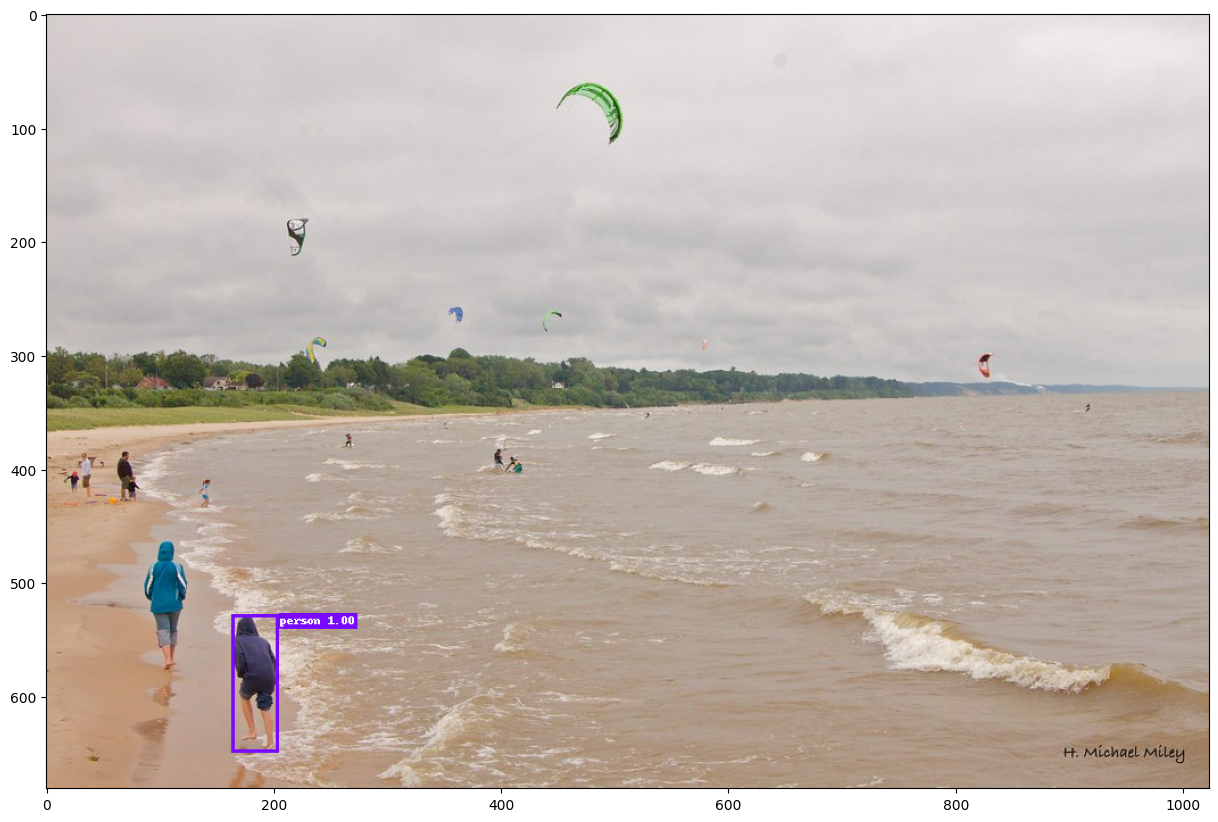

Largest 'person' area: 4927.29px


In [ ]:
# First, let's find the indices of person predictions. The 'person' class
# corresponds to the id 1
person_indices = np.where(final_classes == 1)
# We can then select the person boxes by using the indices we just computed
person_boxes = final_boxes[person_indices]
# As the predicted boxes are normalized between 0 and 1 we need to multiply the
# boxes' (in the format [y0, x0, y1, x1]) by the image's dimensions. The image
# has still shape [1, h, w, 3]
h = image_np.shape[1]
w = image_np.shape[2]
person_boxes_denormalized = person_boxes * [h, w, h, w]

# We can now compute the areas as (y_1 - y_0) * (x_1 - x_0)
person_areas = ((person_boxes_denormalized[:, 2] - person_boxes_denormalized[:, 0])
                * (person_boxes_denormalized[:, 3] - person_boxes_denormalized[:, 1]))

# We use argmax to find the index of the biggest box
largest_person_index = np.argmax(person_areas)

# We can use this index to extract the box from person_boxes (normalized to comply with the visualization function)
largest_person_box = person_boxes[largest_person_index]

# Let's now plot the result by exploiting our previous function, for which we
# build arrays of 1 element for boxes, classes and scores. We first compute the
# corresponding model confidence as well
person_scores = final_scores[person_indices]
largest_person_score = person_scores[largest_person_index]
show_prediction(image_np, np.array([largest_person_box]), np.array([1]),
                np.array([largest_person_score]))

print(f"Largest 'person' area: {person_areas[largest_person_index]:.2f}px")

## Inference
### Over other images
Now you can select any image (either from our image_paths or from your local drive) to test the model.

In [ ]:
def infer(image_path, min_confidence):
  """Function to perform the whole inference process.

  Args:
    image_path: the initial image's path, either local (e.g. ./image.jpg) or
      over the internet
    min_confidence: confidence threshold for predictions
  """
  # We first load the image and display it
  image = load_image_into_numpy_array(image_path)
  plt.imshow(image[0])
  plt.title("Initial image")
  plt.show()

  # We then call the model, process its results and keep only predictions
  # with confidence over the threshold
  results = hub_model(image)
  result = {key:value.numpy() for key,value in results.items()}

  # We select the results and remove the batch dimension
  classes = result['detection_classes'][0].astype(int)
  boxes = result['detection_boxes'][0]
  confidence_scores = result['detection_scores'][0]

  # Optionally, plot the confidence thresholding as well
  # plot_predicted_confidence(confidence_scores, min_confidence)

  over_threshold_mask = confidence_scores >= min_confidence
  final_boxes = boxes[over_threshold_mask]
  final_classes = classes[over_threshold_mask]
  final_scores = confidence_scores[over_threshold_mask]

  # Finally, we display which objects are detected in the image and display the
  # prediction
  print_prediction_count(image, final_classes, final_boxes)
  show_prediction(image, final_boxes, final_classes, final_scores)

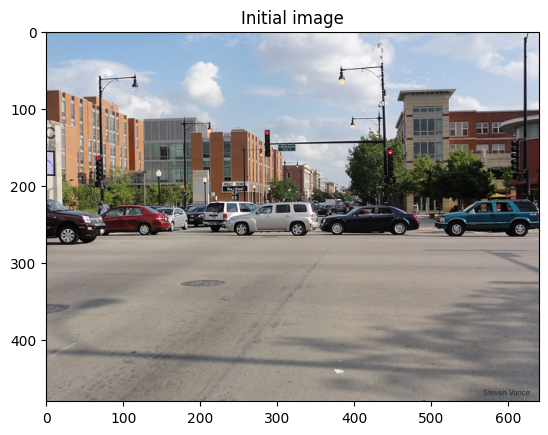

Number of 'person' instances: 1; minimum area: 294px; maximum_area: 294px; average area: 294.0px
Number of 'car' instances: 8; minimum area: 960px; maximum_area: 6700px; average area: 3819.5px
Number of 'traffic light' instances: 4; minimum area: 333px; maximum_area: 585px; average area: 480.25px


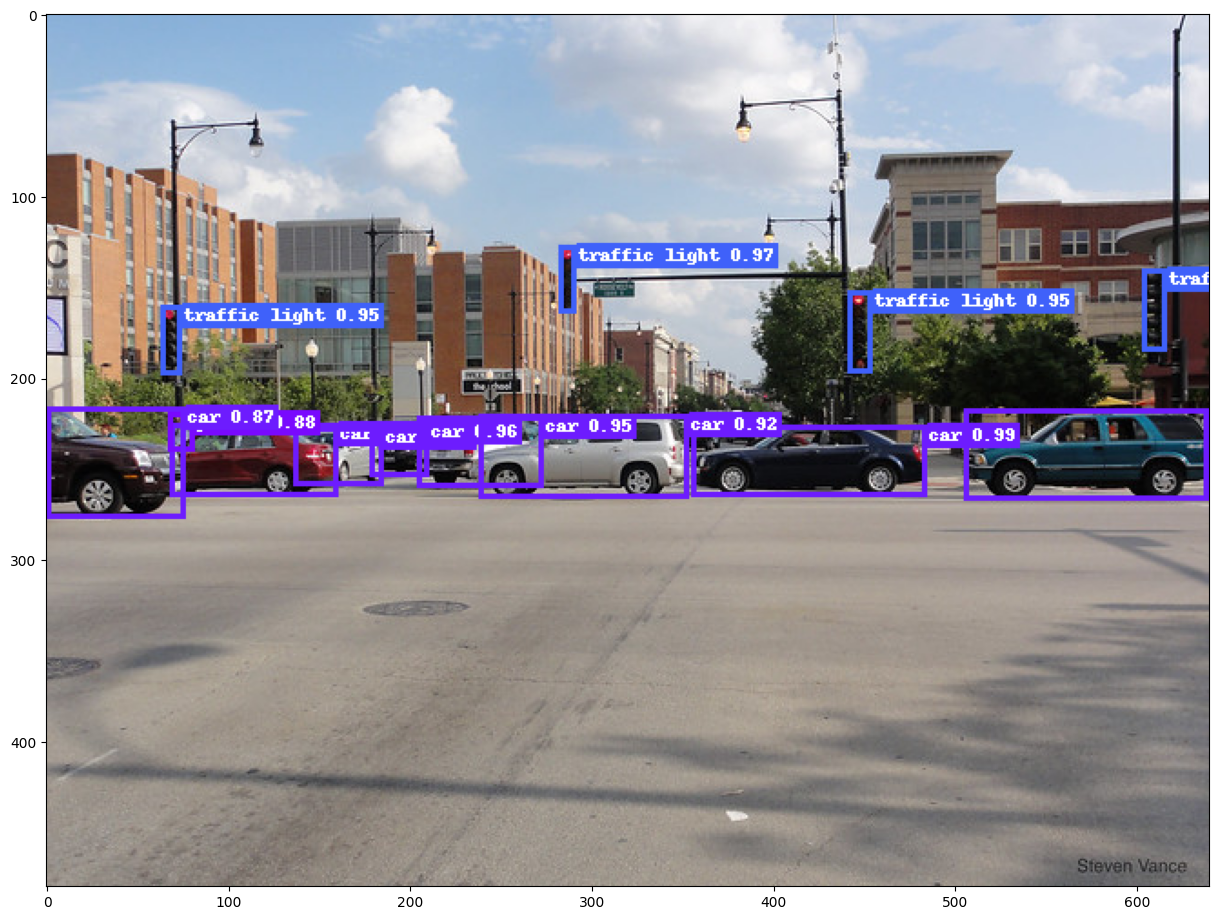

In [ ]:
infer(image_paths['Road'], min_confidence=0.7)

In [ ]:
# You can try with local or other online images as well
# infer("./example_image.jpg", 0.7)